# Bike sharing demand prediction (Kaggle competition)

### Data preprocessing and EDA

Dataset : <a href = https://www.kaggle.com/c/bike-sharing-demand> Kaggle Bike sharing demand competition<a>
#### Steps : 
    1) Data preprocessing 
    2) EDA
    3) Model testing
    4) Hyperparameter tuning

## 3) Model testing

In [1]:
# Import packages

import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error, SCORERS, make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import clone
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the preprocessed data files

train = pd.read_csv("train_preprocessed.csv")

targets = ["casual", "registered", "count"]

train_x = train.drop(targets, axis = 1)
train_y = train[targets]

print("""Train feature shape : {}
Target shape : {}""".format(train_x.shape, train_y.shape))
print("-"*20)
print("""Train features : {}\n
Targets : {}""".format(train_x.columns.tolist(), train_y.columns.tolist()))

Train feature shape : (10886, 13)
Target shape : (10886, 3)
--------------------
Train features : ['season_1', 'season_2', 'season_3', 'season_4', 'weather', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'dayofweek', 'hourofday']

Targets : ['casual', 'registered', 'count']


.

Target variable is a count, which is always non-negative. To avoid predicting any negative values, train the models to predict square roots of casual and registered count seperately, then square and add these values to get total hourly count.

Split the data into train and test to evaluate the model performance on unseen data.

In [3]:
x_tr, x_te, y_tr, y_te = train_test_split(train_x, train_y, test_size=0.2, random_state = 8)
print("""Train data : X = {}, y = {}
Validation data : X = {}, y = {}""".format(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape))

x_tr = x_tr.reset_index(drop = True)
x_te = x_te.reset_index(drop = True)
y_tr = y_tr.reset_index(drop = True)
y_te = y_te.reset_index(drop = True)

Train data : X = (8708, 13), y = (8708, 3)
Validation data : X = (2178, 13), y = (2178, 3)


.

Now let's see how different models perform on the train data. For this, calculate root mean squared logarithmic error and r-squared values for each model with 4 fold cross validation.

In [4]:
# Splitting data for cross validation
rkf = RepeatedKFold(n_splits=4, n_repeats=2, random_state=42)

In [5]:
# Function to calculate RMSLE of one single model

def single_model_rmsle(model, train, count):
    rmsle = np.array([])
    for train_id, test_id in rkf.split(train, count):
        predictor = clone(model)
        
        train_feats = train.iloc[train_id,:]
        test_feats = train.iloc[test_id,:]
        
        train_y = np.sqrt(count[train_id])
        test_y = count[test_id]
        
        predictor.fit(train_feats, train_y)
        preds = np.square(predictor.predict(test_feats))
        
        curr_rmsle = np.sqrt(mean_squared_log_error(y_true=test_y, y_pred=preds))
        rmsle = np.append(rmsle, [curr_rmsle], axis = 0)
        
    return rmsle  

In [6]:
# Functions to predict count of a single model and cross validation scores of the entire model.
def predict_count(model, train_feats, test_feats, train_id, test_id, target):
    tr_target = np.sqrt(target[train_id])
    ts_target = target[test_id]
    
    model_count = clone(model)
    
    model_count.fit(train_feats, tr_target)
    
    count_preds = np.square(model_count.predict(test_feats))
    
    return ts_target, count_preds

def get_model_rmsle(model, predict = "count", train = x_tr, cas_target = y_tr["casual"], reg_target = y_tr["registered"], count = y_tr["count"]):
    rmsle = np.array([])
    r2 = np.array([])
    for train_id, test_id in rkf.split(train, count):
        train_feats = train.iloc[train_id,:]
        test_feats = train.iloc[test_id,:]
        
        if predict == "casual" or predict == "count":
            cts_target, cpreds = predict_count(model, train_feats = train_feats, test_feats = test_feats,
                                  train_id = train_id, test_id = test_id, target = cas_target)
            
            if predict == "casual":
                curr_rmsle = np.sqrt(mean_squared_log_error(y_true=cts_target, y_pred=cpreds))
                rmsle = np.append(rmsle, [curr_rmsle], axis = 0)
                
                curr_r2 = r2_score(y_true=cts_target, y_pred=cpreds)
                r2 = np.append(r2, [curr_r2], axis = 0)
                
            
        if predict == "registered" or predict == "count":
            rts_target, rpreds = predict_count(model, train_feats = train_feats, test_feats = test_feats,
                                  train_id = train_id, test_id = test_id, target = reg_target)
            
            if predict == "registered":
                curr_rmsle = np.sqrt(mean_squared_log_error(y_true=rts_target, y_pred=rpreds))
                rmsle = np.append(rmsle, [curr_rmsle], axis = 0)
                
                curr_r2 = r2_score(y_true=rts_target, y_pred=rpreds)
                r2 = np.append(r2, [curr_r2], axis = 0)
                
        
        if predict == "count":
            count_ts_target = count[test_id]
            preds = cpreds+rpreds
            curr_rmsle = np.sqrt(mean_squared_log_error(y_true=count_ts_target, y_pred=preds))
            rmsle = np.append(rmsle, [curr_rmsle], axis = 0)
            
            curr_r2 = r2_score(y_true=count_ts_target, y_pred=preds)
            r2 = np.append(r2, [curr_r2], axis = 0)
                
    return rmsle, r2

In [7]:
# Models to test out
models = [("linear", LinearRegression(n_jobs = -1)),
         ("tree", DecisionTreeRegressor(random_state = 42)),
         ("gradient_boost", GradientBoostingRegressor(random_state=42)),
         ("hist_gb", HistGradientBoostingRegressor(random_state=42)),
         ("rf", RandomForestRegressor(random_state = 42, n_jobs = -1)),
         ("xgbr", XGBRegressor(random_state = 42, n_jobs = -1)),
         ("lgbr", LGBMRegressor(random_state=42, n_jobs = -1)),
         ("cat", CatBoostRegressor(random_state=42, silent = True))]

In [28]:
# with rmsle and r2
model_performances = {}
for model_tuple in models:
    model_name = model_tuple[0]
    model_rmsle, model_r2 = get_model_rmsle(model_tuple[1])
    
    model_performances.update({model_name:[model_rmsle, model_r2]})
    

In [29]:
model_performance_df = pd.DataFrame({"mean_rmsle":[a[0].mean() for a in model_performances.values()],
                                    "mean_r2":[a[1].mean() for a in model_performances.values()]}, index = model_performances.keys())

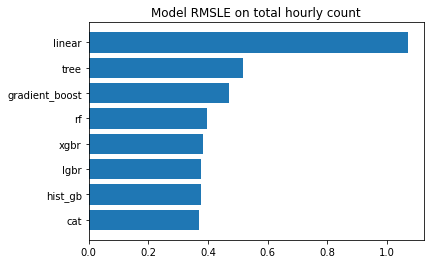

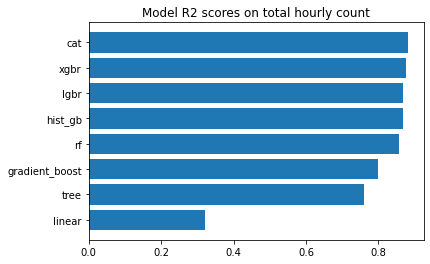

In [30]:
plt.barh(model_performance_df.sort_values("mean_rmsle").index, model_performance_df.sort_values("mean_rmsle")["mean_rmsle"])
plt.title("Model RMSLE on total hourly count")
plt.show()

plt.barh(model_performance_df.sort_values("mean_r2").index, model_performance_df.sort_values("mean_r2")["mean_r2"])
plt.title("Model R2 scores on total hourly count")
plt.show()

.

All but linear regression model perform very well. 

## 4) Hyperparameter tuning

Let's see if tuning model hyperparameters improves the performance or not.

In [38]:
# RMSLE scorer function for hyperparams tuning:
def rmsle_func(y, ypred):
    return np.sqrt(mean_squared_log_error(y_true=np.square(y), y_pred=np.square(ypred)))

CatBoost models are built such that they give the best result with default parameters. So, let's tune a random forest model. Hyperparameters tuning needs to be done seperately on casual and registered count target.

#### -> Casual Model:

In [37]:
# Default hyperparams
rf_cas = RandomForestRegressor(random_state = 42, n_jobs = -1).fit(x_tr, np.sqrt(y_tr["casual"]))
rf_cas_preds = np.square(rf_cas.predict(x_te))
print(np.sqrt(mean_squared_log_error(y_true=y_te["casual"], y_pred=rf_cas_preds)))

0.5152271553790302


In [41]:
# RandomizedSearch tuning hyperparams
sqrt_y_casual_tr = np.sqrt(y_tr["casual"])
casual_params_rcv = {"n_estimators":[50,100,200,500],
                "max_depth":[10,12,14,16,None],
                "min_samples_split":[2,5,10,15],
                "min_samples_leaf":[1,2,3,4],
                "max_features":[4,5,6,7,8,"auto"],
                "max_samples":[0.45,0.6,0.75,None]}

rf_cas_rcv = RandomForestRegressor(n_jobs = -1, random_state=42)

random_grid_cas = RandomizedSearchCV(estimator=rf_cas_rcv, param_distributions=casual_params_rcv,
                                 scoring = {"rmsle":make_scorer(rmsle_func), "r2":make_scorer(r2_score)}, cv = 4, n_iter = 50,
                                 verbose = 2, n_jobs = -1, refit = "rmsle")
random_grid_cas.fit(x_tr, sqrt_y_casual_tr)


Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 12, 14, 16, None],
                                        'max_features': [4, 5, 6, 7, 8, 'auto'],
                                        'max_samples': [0.45, 0.6, 0.75, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [50, 100, 200, 500]},
                   refit='rmsle',
                   scoring={'r2': make_scorer(r2_score),
                            'rmsle': make_scorer(rmsle_func)},
                   verbose=2)

In [42]:
best_cas_test_preds = np.square(random_grid_cas.predict(x_te))
print(np.sqrt(mean_squared_log_error(y_pred=best_cas_test_preds, y_true = y_te["casual"])))

0.5529566552904486


#### -> Registered model:

In [44]:
rf_reg = RandomForestRegressor(random_state = 42, n_jobs = -1).fit(x_tr, np.sqrt(y_tr["registered"]))
rf_reg_preds = np.square(rf_reg.predict(x_te))
print(np.sqrt(mean_squared_log_error(y_true=y_te["registered"], y_pred=rf_reg_preds)))

0.3850123388116811


In [45]:
# RandomizedSearch tuning hyperparams for casual count models
sqrt_y_registered_tr = np.sqrt(y_tr["registered"])
registered_params_rcv = {"n_estimators":[50,100,200,500],
                "max_depth":[10,12,14,16,None],
                "min_samples_split":[2,5,10,15],
                "min_samples_leaf":[1,2,3,4],
                "max_features":[4,5,6,7,8,"auto"],
                "max_samples":[0.45,0.6,0.75,None]}

rf_reg_rcv = RandomForestRegressor(n_jobs = -1, random_state=42)

random_grid_reg = RandomizedSearchCV(estimator=rf_cas_rcv, param_distributions=registered_params_rcv,
                                 scoring = {"rmsle":make_scorer(rmsle_func), "r2":make_scorer(r2_score)}, cv = 4, n_iter = 50,
                                 verbose = 2, n_jobs = -1, refit = "rmsle")
random_grid_reg.fit(x_tr, sqrt_y_registered_tr)


Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 12, 14, 16, None],
                                        'max_features': [4, 5, 6, 7, 8, 'auto'],
                                        'max_samples': [0.45, 0.6, 0.75, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [50, 100, 200, 500]},
                   refit='rmsle',
                   scoring={'r2': make_scorer(r2_score),
                            'rmsle': make_scorer(rmsle_func)},
                   verbose=2)

In [46]:
best_reg_test_preds = np.square(random_grid_reg.predict(x_te))
print(np.sqrt(mean_squared_log_error(y_pred=best_reg_test_preds, y_true = y_te["registered"])))

0.5261135859288065


.

In both cases, random forest with default parameteres performs the best.

Finally, let's look at feature importances to see which features are most relevant in predicting the demand. As catboost model gives the least RMSLE, use catboost to get feature importances.

In [52]:
cat_cas = CatBoostRegressor(silent = True, random_state=42).fit(x_tr, np.sqrt(y_tr["casual"]))
cat_reg = CatBoostRegressor(silent = True, random_state=42).fit(x_tr, np.sqrt(y_tr["registered"]))

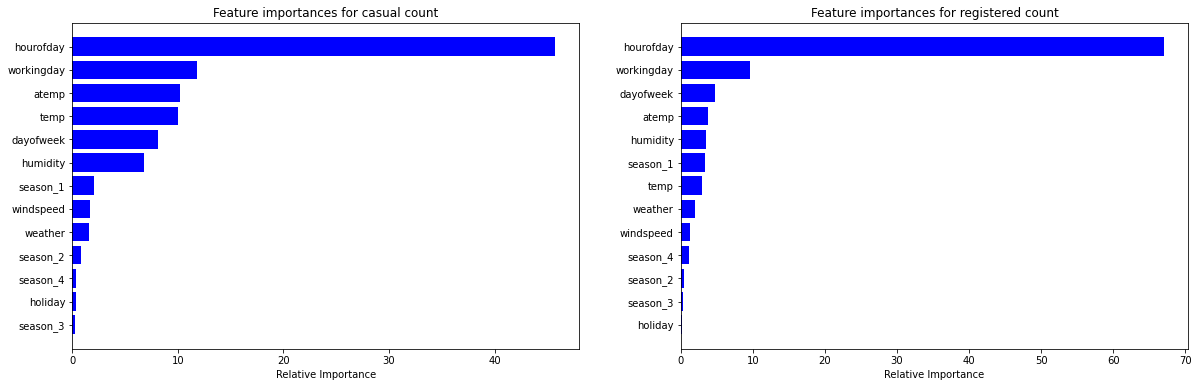

In [79]:
features = x_tr.columns
importances_cas = cat_cas.feature_importances_
importances_reg = cat_reg.feature_importances_
indices_cas = np.argsort(importances_cas)
indices_reg = np.argsort(importances_reg)

plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.barh(range(len(indices_cas)), importances_cas[indices_cas], color='b', align='center')
plt.yticks(range(len(indices_cas)), [features[i] for i in indices_cas])
plt.title('Feature importances for casual count')
plt.xlabel('Relative Importance')

plt.subplot(1,2,2)
plt.barh(range(len(indices_reg)), importances_reg[indices_reg], color='b', align='center')
plt.yticks(range(len(indices_reg)), [features[i] for i in indices_reg])
plt.title('Feature importances for registered count')
plt.xlabel('Relative Importance')

plt.show()

In both cases, hourofday is the modt important feature, followed by workingday.